---
title: "Ionosphere module"
bibliography: ../bibliography.bib
---


# Ionospheric delay in GNSS observations
Ionospheric delay is one of the key factors degrading GNSS positioning. Long-established methods of dealing with it include modeling ionospheric delay or using a combination of observations at two frequencies – iono-free, which eliminates first-order ionospheric delay at the cost of increased observation noise [@Handbook; @HofmannWellenhof2008].  Ionospheric modeling and monitoring is a broad field of GNSS-related research (e.g [@Mannucci1998; @Schaer1999]). GNX-py offers a number of functionalities for measuring, modeling, and monitoring the spatial and temporal scale of changes in the ionosphere. Below, we will present the theoretical background of the methods used and then move on to discuss the implemented algorithms.

**Notation**

- $f_i$: carrier frequency $i$ [Hz],
- $\lambda_i = c/f_i$ - wavelength,
- $c$: speed of light
- $N_e(s)$: electron density [el/m$^3$]
- $\mathrm{STEC} = \int_{\mathrm{LOS}} N_e(s)\,ds$ [el/m$^2$],
- $1~\mathrm{TECU} = 10^{16}~\mathrm{el/m^2}$
- $\rho$: geometric range,
- $T$: tropospheric delay
- $\delta t_r, \delta t_s$: receiver/satellite clock offsets
- $P_i$: code measurement  on $f_i$ [m]
- $\Phi_i = \lambda_i \varphi_i$: carrier phase observation [m]
- $d^{P}_{(\cdot),i}, d^{L}_{(\cdot),i}$: hardware delays,
- $N_i$: carrier ambiguity


## Definition of STEC
Ionospheric delay on the satellite-receiver path is defined as:
$$
\mathrm{STEC} = \int_{\mathrm{LOS}} N_e(s)\,ds \qquad [\mathrm{el/m^2}]
$$
The commonly accepted unit for describing STEC is TECU, Total Electron Content Units. 1 TECU is $10^{16} \space [el/m^2]$.

## Ionospheric delay
In the case of GNSS observations, we are most often interested in the delay in meters for code and phase observation data.
$$
I_i = \frac{40.3\cdot 10^{16}}{f_i^2}\,\mathrm{STEC}
$$

Here $I_i$ is an ionospheric delay in the unit of meters for signal at frequency $i$. Ionospheric delay causes a “delay” in code observations and an “advance” in phase observations, so the correction is entered into the equation with the opposite sign.
$$
P_i: +I_i \quad\text{(group delay)}, \qquad
\Phi_i: -I_i \quad\text{(phase advance)}
$$



## Observation equations
Recording our code and phase observations as $P_i$ and $\Phi_i$, respectively:
$$\begin{aligned}
P_{i} &= \rho + c(\delta t_r-\delta t_s) + T + I_i
+ d^{P}_{r,i}-d^{P}_{s,i} + \varepsilon_{P_i}, \\[2mm]
\Phi_{i} &= \rho + c(\delta t_r-\delta t_s) + T - I_i
+ \lambda_i N_i + d^{L}_{r,i}-d^{L}_{s,i} + \varepsilon_{\Phi_i}.
\end{aligned}$$


STEC measurement using GNSS is possible thanks to a combination of observations at two frequencies. The so-called geometry-free combination eliminates all non-dispersive factors affecting the observation, such as tropospheric delay.

$$\begin{aligned}
P_{\mathrm{GF}} &= P_1 - P_2 \;=\; (I_1 - I_2)
+ \Big[(d^P_{r,1}-d^P_{r,2})-(d^P_{s,1}-d^P_{s,2})\Big] + \eta_P,\\[1mm]
\Phi_{\mathrm{GF}} &= \Phi_1 - \Phi_2 \;=\; -(I_1 - I_2)
+ (\lambda_1N_1-\lambda_2N_2)
+ \Big[(d^L_{r,1}-d^L_{r,2})-(d^L_{s,1}-d^L_{s,2})\Big] + \eta_\Phi.
\end{aligned}$$


The remaining biases are differences in hardware delays between two frequencies for satellites and receivers, and in the case of phase observations, differences in phase ambiguities. Satellite DCB can be introduced as an external correction from daily or monthly products of various IAACs, e.g., CODE. Receivers DCB can also be obtained from external sources, but they are obviously not available for every receiver, so they must be estimated for absolute STEC measurement. In GNX-py, this is done either through a calibration procedure based on an external model, e.g., GIM, from the day of observation or the day preceding it, or through PPP in UDUC mode and determining biases from OSB delays obtained in the estimation process. Obtaining STEC observations is performed by applying following formulas:


$$
\mathrm{STEC}^{(P)} =
\frac{P_{\mathrm{GF}} - \mathrm{DCB}^{P}_{12}}
{40.3\left(\tfrac{1}{f_1^2}-\tfrac{1}{f_2^2}\right)}
$$

and from phase observations (with constant $B_\Phi$):

$$
\mathrm{STEC}^{(\Phi)} =
-\frac{\Phi_{\mathrm{GF}} - B_\Phi}
{40.3\left(\tfrac{1}{f_1^2}-\tfrac{1}{f_2^2}\right)}
$$



$B_{\Phi}$ is a linear combination of phase ambiguities of signals at both frequencies resulting from the creation of a geometry-free combination. Due to this bias, the GF observation derived from the phase, although not affected by noise to the same extent as the code observation, is scaled by a bias unique to a given satellite. To remove it, a phase-to-code leveling technique is used, i.e., fitting the phase observation into the code observation [@Mannucci1998]. This allows for obtaining a precise, noise-free STEC on a real scale. It is also possible to use denoising filters on code observations and not to rely on phase observations at all.

$$
\tilde{L}_4^{(n)} = L_4^{n} + \frac{1}{K} \sum_{k=1}^{K} \Bigr[\bigl( L_4^{(n)} - P_4^{(k)} \bigr) \Bigr]
$$

**where:**
- $\tilde{L}_4^{(n)}$ – smoothed carrier phase geometry-free observation at epoch $n$,
- $P_4^{(k)}$ – code geometry-free observation at epoch $k$,
- $L_4^{(k)}$ – phase geometry-free observation at epoch  $k$,
- $K$ – number of samples used for smoothing

For smoothing process window size parameter - $K$ is defined,thus, the smoothing procedure for observations in epoch $n$ is performed by adding to observation $L_4^{n}$ the average difference between this observation and $K$ code observations in epochs adjacent to $n$, i.e., $k_1 = n-K/2, K = n+K/2 $. You can find an example below. Alternatively, instead of phase leveling, we can use various techniques for noise reduction in code observations, such as Chebyshev and Savitzky-Golay filters [@SavitzkyGolay1964; @DSPGuide_Chebyshev; @Arikan2008].

In ionosphere modeling using GNSS, it is usually assumed that electrons are concentrated in an infinitely thin layer of the atmosphere at a certain altitude, e.g., 350, 400, or 450 km. The conversion of measured STEC to VTEC and vice versa using a mapping function is based on this assumption. Assume shell height $h_{\mathrm{ion}}$ and Earth radius $R_E$:

$$
M(E) = \frac{1}{\sqrt{1-\left(\tfrac{R_E}{R_E+h_{\mathrm{ion}}}\cos E\right)^2}}
$$

$$
\mathrm{STEC} \approx M(E)\cdot \mathrm{VTEC}, \qquad
\mathrm{VTEC} \approx \frac{\mathrm{STEC}}{M(E)}
$$
This is a simple mapping function, but you can find several others, sometimes more advanced ones, in the literature on the subject. In the next section, we will move on to an example of using GNX-py to measure STEC for a single station and compare ionosphere models using built-in tools.

## Example of STEC processing in GNX-py
Let's now move on to an example of STEC measurement in GNX-py.  The procedure is as follows:
- we obtain the coordinates of the satellites at the time of signal transmission (see the Introduction notebook)
- we introduce corrections to the observations (we only need to introduce what is not common to both frequencies - PCO of satellites and receiver, and - for already differentiated observations - DCB of satellites and receiver.
- detection of cycle slips and loss of tracking - we must detect them, otherwise they will cause problems during leveling. In GNX-py, we divide observations to the satellite into arcs between cycle slips and tracking gaps, which is why you see indexes such as G01_0_1 in our dataframes. They should be interpreted as: observation to satellite G01, 0 - index of the arc between tracking losses, 1 - index of the arc between cycle slips
- phase to code leveling - we smooth observations according to the method described above
- conversion of meters of delay to TEC


For simplicity, we have enclosed the entire pipeline in a single class—$TECSession$—which is managed by the configuration class—$TECConfig$. In the configuration class, we place the processing parameters, which are then sent to $TECSession$. This gives you a ready-made pipeline that you can modify according to your needs. You can view all the parameters of the configuration class in the orbits/config.py module. Here, we will only fill in those necessary for our measurements.

In [28]:
import gps_lib as gnx
import numpy as np
import warnings
from datetime import datetime
from tools import df_head
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(threshold=np.inf, linewidth=200, suppress=True, precision=3)



In [29]:
OBS_PATH='../data/BOR100POL_R_20240350000_01D_30S_MO.rnx'
NAME = OBS_PATH.split('/')[-1][:4]


NAV = '../data/BRDC00IGS_R_20240350000_01D_MN.rnx'
SP3_LIST=[
'../data/COD0OPSFIN_20240340000_01D_05M_ORB.SP3',
'../data/COD0OPSFIN_20240350000_01D_05M_ORB.SP3',
'../data/COD0OPSFIN_20240360000_01D_05M_ORB.SP3']
ATX_PATH='../data/ngs20.atx'
DCB_PATH= '../data/COD0OPSFIN_20240350000_01D_01D_OSB.BIA'
GIM='../data/COD0OPSFIN_20240350000_01D_01H_GIM.INX'

TLIM = [datetime(2024,2,4,0,0,0),
        datetime(2024,2,4,23,59,30)]

SYS= 'G'
DOY=35

We will use the observation file from the BOR1 station for processing. Since the data from the station was used to generate the GIM, its DCB for GPS and Galileo is present in the IONEX file. If we did not have the receiver's DCB, we could either perform “on the fly” calibration using our GIM, or use our own DCB obtained, for example, from PPP measurements in undifferenced uncombined mode (see PPP notebook). Experiments with GNX-py prove that the latter method gives quite good agreement with the DCB from the IONEX file, typically at the level of 0.5-1.5 ns. For safety, you can always average the DCB from both sources. An example of calibration can be found in a separate notebook. In this example, we will perform an STEC measurement and calculate it from three additional models: GIM, Klobuchar, and NTCM. Next, we will analyze the obtained values.

We will obtain the satellite coordinates from SP3 files, while the PCO of the satellites and receiver from the ANTEX file. Below you will find our configuration class. I have added comments to the selected elements so that you know what we are doing and why.

In [30]:
config = gnx.TECConfig(
   obs_path=OBS_PATH,# Observation file
   nav_path=NAV, # navigation file - we need it for screening and for Klobuchar/NTCM model computation (GPSA, GPSB and GAl coeffs)
   sp3_path=SP3_LIST, # satellite coordinates
   gim_path=GIM, # IONEX for GIM STEC computation and source of satellite DCB

   sys=SYS, # SYSTEM/S used - STEC is measured for GPS and GAL separately, so here we should use only {G} or {E}
   gps_freq='L1L2', # Signals used
   windup=True, # we  need windup for STEC measurement
   rel_path=False,#we dont need relativistic path range correction for STEC measurement
   sat_pco='los',
   rec_pco=True,# ... and reciever pco
   atx_path=ATX_PATH, # ... so here we have ATX file
   add_dcb=True, # we want to use DCB


   add_sta_dcb=True, # we want to use station DCB
   rcv_dcb_source='gim', # possible: gim | calibrate | defined, here we use station DCB from GIM
   screen=True, # we want to screen for unhealthly satellites
    ev_mask = 20,


   station_name=NAME, # station name
   day_of_year=DOY, # Day of year - must have for Klobuchar/NTCM models


   ionosphere_model='gim', # ...using GIM
   use_iono_rms=True, # ... with STEC RMS
   compare_models=['ntcm','klobuchar'],# we'd like to compare NTCM and Klobuchar models


   troposphere_model=False, # we dont need troposphere correction


   use_gfz=True,# GFZRNX for fast obs file reading


   leveling_ws=50,# window sie for leveling (K parameter) 50 is safe value


   median_leveling_ws=50 # the same parameter but for median moving window leveling - alternative to phase leveling
    )

Okay, after creating the configuration, we introduce it as an attribute to the TECSession class and run the calculations using the run() method.

In [31]:
controller = gnx.TECSession(config=config)
obs_tec = controller.run()

The resulting obs_tec dataframe contains all observational data and preprocessing results. The calculated STEC and modelled corrections can be found in the columns below.

In [32]:
df_head(obs_tec[['ion','klobuchar','ntcm']],nrows=5,ncols=5) # ION = GIM

| sv      | time                |   ion |   klobuchar |   ntcm |
|---------|---------------------|-------|-------------|--------|
| G02_0_1 | 2024-02-04 00:00:00 | 1.754 |       1.939 |  1.504 |
| G02_0_1 | 2024-02-04 00:00:30 | 1.765 |       1.945 |  1.507 |
| G02_0_1 | 2024-02-04 00:01:00 | 1.776 |       1.952 |  1.509 |
| G02_0_1 | 2024-02-04 00:01:30 | 1.786 |       1.959 |  1.512 |
| G02_0_1 | 2024-02-04 00:02:00 | 1.797 |       1.966 |  1.514 |

Please note that all correction values are in metres of delay on L1, so we will convert them to TECU for the convention in the STEC analysis. Output STEC is in electrons, so we convert it to TECU by dividing it by $1^{16}$.

In [33]:
obs_tec[[c for c in obs_tec.columns if '_tec' in c]] /=1e16

In [34]:
df_head(obs_tec[[c for c in obs_tec.columns if '_tec' in c]],nrows=5,ncols=7,floatfmt = ".2f",truncate_str=10)


| sv      | time                |   leveled_tec |   code_tec |   leveled_tec_sg |   leveled_tec_cheby |   phase_tec |
|---------|---------------------|---------------|------------|------------------|---------------------|-------------|
| G02_0_1 | 2024-02-04 00:00:00 |          8.24 |       7.48 |             7.54 |                6.38 |     -180.61 |
| G02_0_1 | 2024-02-04 00:00:30 |          8.26 |      10.46 |             7.58 |                6.42 |     -180.58 |
| G02_0_1 | 2024-02-04 00:01:00 |          8.18 |       7.89 |             7.63 |                6.47 |     -180.54 |
| G02_0_1 | 2024-02-04 00:01:30 |          8.19 |       8.12 |             7.68 |                6.51 |     -180.52 |
| G02_0_1 | 2024-02-04 00:02:00 |          8.12 |       9.00 |             7.72 |                6.56 |     -180.47 |

Let's take a look at the collection of continuous observations from satellites that we have gathered. We will select one of them to show the differences between code and phase STEC mentioned in the previous section.

<Axes: title={'center': 'Observations per satellite'}, xlabel='Number of observations', ylabel='sv'>

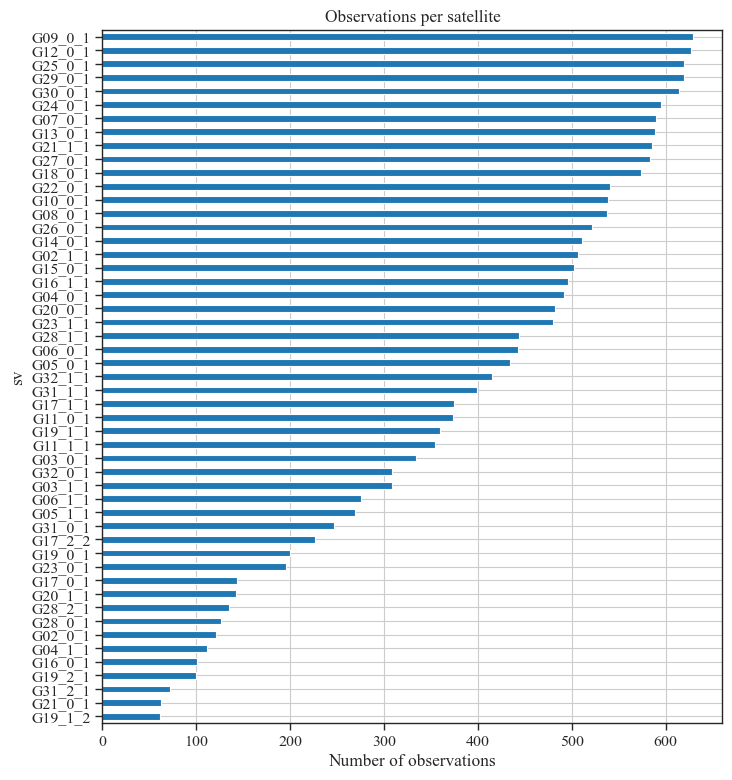

In [35]:
obs_tec.groupby('sv').size().sort_values().plot(kind='barh', xlabel='Number of observations', title='Observations per satellite',figsize=(8,9),grid=True)


In the case of our station, I recommend taking a look at G09_0_1, because it has a lot of observations and you can also clearly see the effect of phase ambiguity.



To plot STEC for this satellite, you can use the auxiliary function $plot_stec$.  Using the function you will see:

- STEC from code observations, significantly noisy,
- STEC smoothed with the Savitsky-Golay filter
- STEC from phase observations, levelled to STEC from code observations

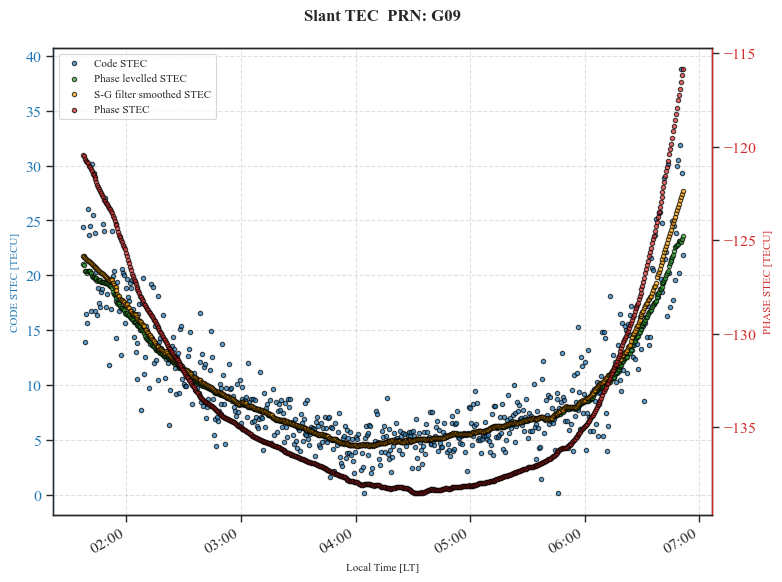

In [36]:
from tools import plot_stec
plot_stec(
        obs_tec,
        "G09_0_1"
    )

With the STEC measured, corrected for the DCB of the satellites and receiver, and smoothed using phase observations, we can perform a series of activities. One of them may be the estimation of VTEC above the station during the observation period. To do this, let's use a tool from the $tools.py$ module - VTECZenithEstimator. It uses the Whittaker–Eilers smoother to estimate the VTEC at the zenith from observations in a given epoch. Due to the specific nature of GNSS measurements, we rarely have the opportunity to observe a satellite directly at the zenith continuously, so we use interpolation on the observations closest to zenith. Whittaker–Eilers smoothing allows for a compromise between data fit and signal smoothness. VTECZenithEstimator smoothing parameters are $lam$ and $order$.  Below you'll find an brief explanation of their purpose.  $lam$ parameter controls the trade-off between fidelity to the input data and the smoothness of the output. Small values of $lam$ keep the smoothed series very close to the raw observations, with little suppression of noise. Large values of lam enforce stronger smoothness, producing a cleaner long-term trend but removing short-term variations. In practice, $lam$ acts like a slider between “follow the data closely” and “ignore details and keep only the trend.” $order$ defines what kind of smoothness is enforced:

- $order=1$ penalizes changes in slope, encouraging the output to be nearly constant within the chosen scale.

- $order=2$ penalizes changes in curvature, encouraging the output to follow a nearly linear trend.

Higher orders continue this pattern, pushing the output toward low-degree polynomial shapes. In our case, $order=2$ works good because it preserves linear trends while removing small-scale noise, and $lam$ is tuned depending on how aggressive the smoothing should be.

In [37]:
from tools import VTECZenithEstimator

In [38]:
est = VTECZenithEstimator(
    df=obs_tec,
    time_col="LT", # LT or time
    elev_col="ev",# elevation column
    stec_col="leveled_tec", # STEC source column, try other sources
    sv_col="sv", # PRN identifier column/index
    min_elev_deg=60, # minimum elevation of satellites used for zenith VTEC interpolation
    resample_freq="600S", # resampling
    smooth_method="whittaker", # method
    smooth_params={"lam": 50, "order": 2}  # method parameters
)


df_zen, zen =est.run()

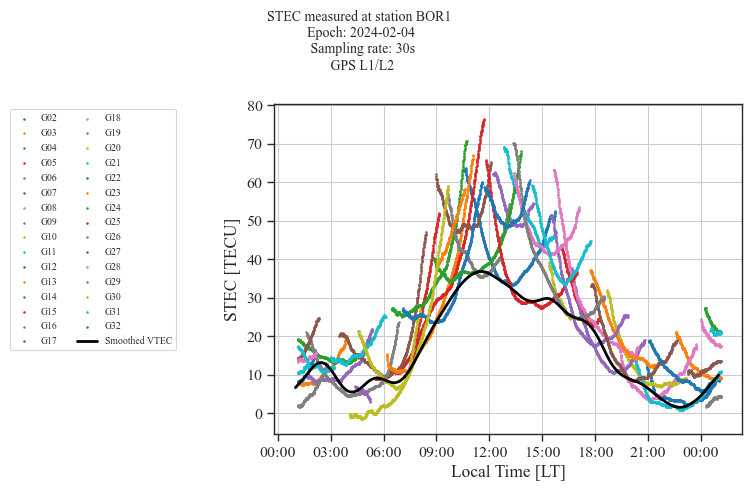

In [39]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
obs_tec['sat']=obs_tec.index.get_level_values('sv').str[:3] # removing arc signatures
fig, ax = plt.subplots(figsize=(8,5))
fig.suptitle(f'STEC measured at station {NAME} \nEpoch: 2024-02-04\n Sampling rate: 30s\n GPS L1/L2',fontsize=10)
for sv, gr in obs_tec.groupby('sat'):
    gr=gr.reset_index()
    ax.scatter(gr['LT'], gr['leveled_tec'], label=sv[:3],s=1)

    ax.set_ylabel('STEC [TECU]')
    ax.set_xlabel('Local Time [LT]')
    ax.grid()
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.plot(zen['LT'],zen['vtec_smooth'],c='black',linewidth=2,label='Smoothed VTEC')
ax.legend(loc='best',ncol=2,bbox_to_anchor=(-0.2,1),fontsize=7)
plt.tight_layout()


In [40]:
df_head(zen,nrows=5,ncols=7,floatfmt = ".2f",truncate_str=10)

|   index | LT                  |   vtec |    ev |    M |   nsat |   vtec_smooth |
|---------|---------------------|--------|-------|------|--------|---------------|
|    0.00 | 2024-02-04 01:00:00 |   7.52 | 84.00 | 1.00 |   1.00 |          6.60 |
|    1.00 | 2024-02-04 01:10:00 |   7.62 | 84.51 | 1.00 |   1.00 |          7.44 |
|    2.00 | 2024-02-04 01:20:00 |   7.39 | 82.91 | 1.01 |   1.00 |          8.30 |
|    3.00 | 2024-02-04 01:30:00 |   7.58 | 79.40 | 1.02 |   1.00 |          9.20 |
|    4.00 | 2024-02-04 01:40:00 |   7.50 | 75.30 | 1.03 |   1.95 |         10.14 |

In the $zen$ dataframe, in the $vtec\_smooth$ column, you will find the estimated VTEC above the station. The technique presented here is not the most precise, but it allows us to obtain some very specific, even approximate, information from the measurements.

Remember that at the beginning we selected the $compare\_models$ parameter and chose the Klobuchar and NTCM models. We also calculated the GIM model, as we are taking the DCB from it anyway. Using the STECModelComparator tool, we can compare these three models in relation to the measured STEC. An example is provided below.



In [41]:
from tools import STECModelComparator
K = 1/0.16
cmp = STECModelComparator(
    df=obs_tec,
    x_col='leveled_tec',
    model_cols=['ion', 'klobuchar', 'ntcm'],     # add models you'd like to compare
    model_names=['GIM', 'Klobuchar', 'NTCM G'],  # Model labels for plotting
    scale=K,                                     # model scale, K = 1/0.16 - meters to TECU
    gridsize=80,
    mincnt=1
)




$report()$ method returns an array with statistics of the differences between the modelled measured STEC, as well as graphs visualizing these statistics.
A hexbin graph (2D histogram) was used to assess model-measurement agreement, where x-axis represents the measured STEC and y-axis represents the modelled STEC, and the color represents the number of observations in the bin. A reference line y=x and a linear regression $y = a·x + b$ (reporting a, b, and $R^2$) were plotted on each panel. Additionally, the following metrics were calculated: Bias, MAE, STD, RMS, Corr, $R^{2}$ for each model. The colored bar describes the number of points in the bin.

The second graph is an error histogram. The graph shows the bias value as a solid line and zero as a dotted line. On the X-axis, we have the error value—the difference between the measurement and the model—and on the Y-axis, the number of measurements.

The statistics table can be displayed using the print() function.

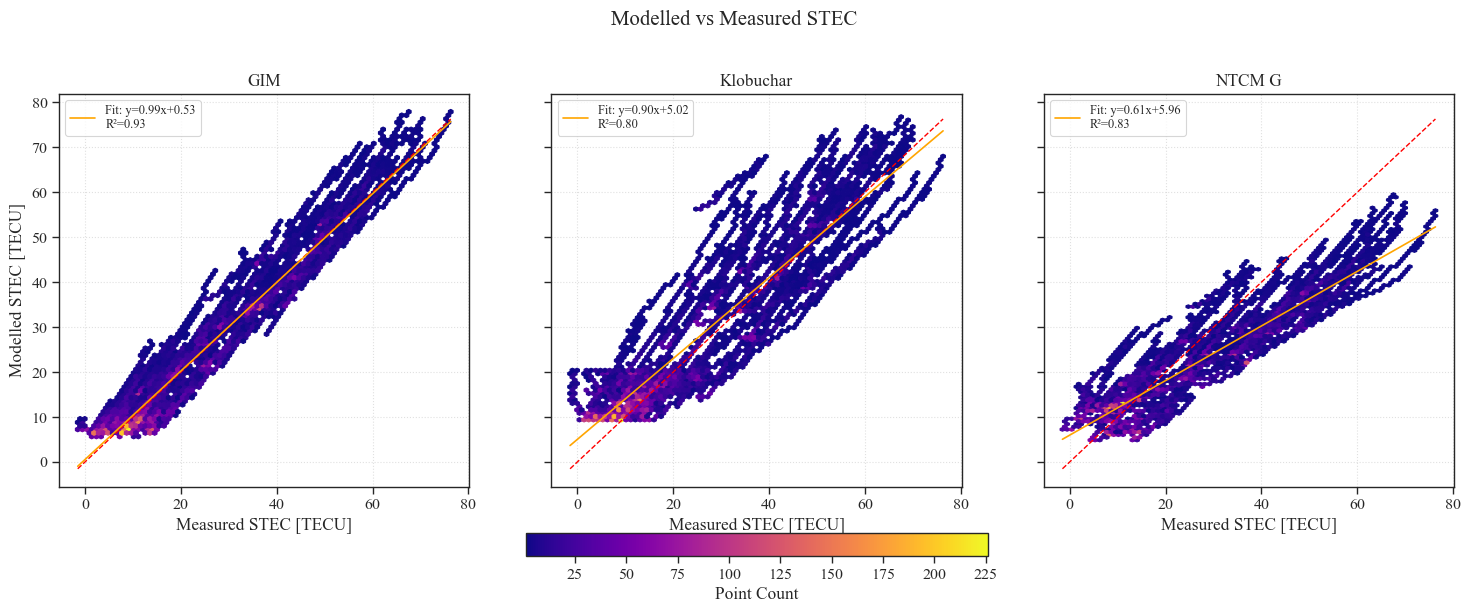

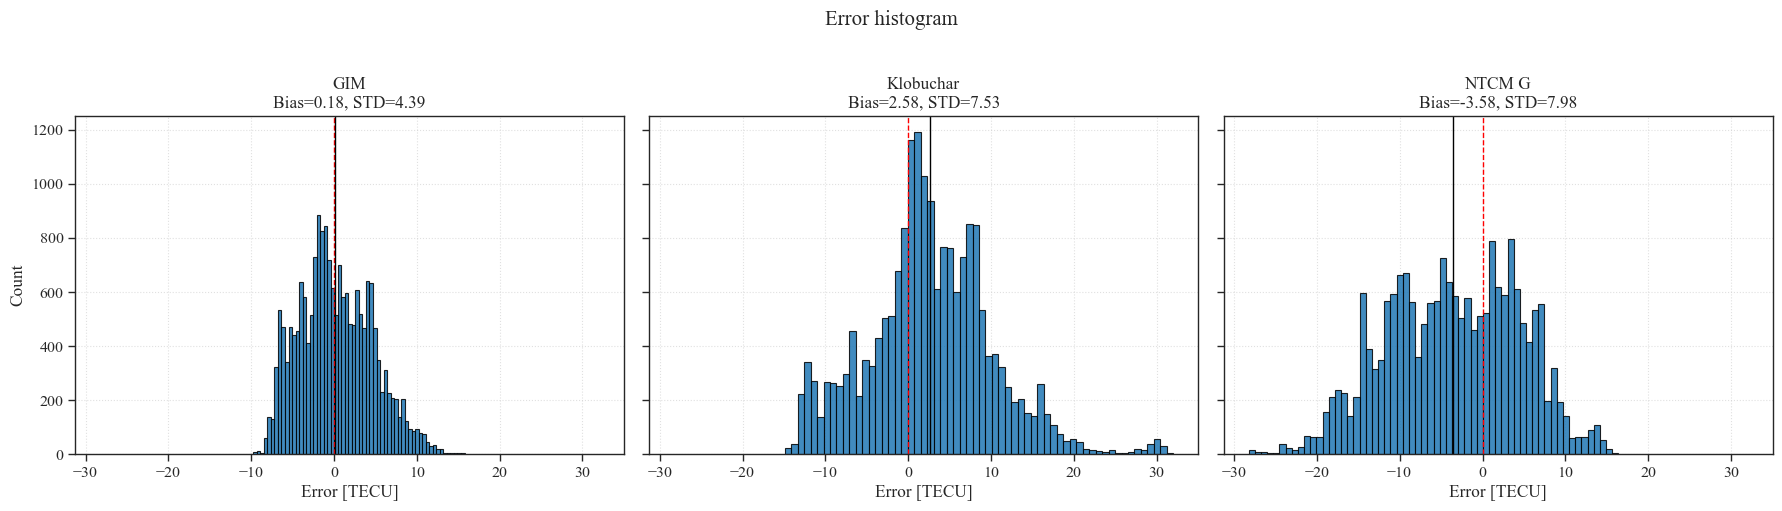

In [45]:
stats_table = cmp.report(
    title="Modelled vs Measured STEC",
    show_hex=True,
    show_hist=True,
    return_stats=True
)


A cursory analysis of the figures leads to three conclusions:

1) The GIM model is the best fit for the measurements out of all three models. It cannot be overlooked that in the measured STEC we use the DCB of satellites and receivers estimated in the GIM generation process

2) The Klobuchar model twice the standard deviation and a tendency to slightly overestimate STEC values.

3) The NTCM model has a slightly higher STD than Klobuchar, and is clearly biased towards underestimating STEC values.

Keep in mind that we are still talking about a single day and a single station, so we cannot draw any far-reaching conclusions about the quality of the models based on this analysis. This example is intended to demonstrate the capabilities of the Ionosphere module in terms of STEC analysis for a single station.




In [46]:
stats_table.set_index('Model',inplace=True)
df_head(stats_table,ncols=10,floatfmt = ".2f")

| Model     |        N |   Bias |   STD |   RMS |   MAE |   Corr |   R2 |   Slope |   Intercept |
|-----------|----------|--------|-------|-------|-------|--------|------|---------|-------------|
| GIM       | 19367.00 |   0.18 |  4.39 |  4.39 |  3.60 |   0.97 | 0.93 |    0.98 |        0.53 |
| Klobuchar | 19367.00 |   2.58 |  7.53 |  7.96 |  6.13 |   0.90 | 0.80 |    0.90 |        5.02 |
| NTCM G    | 19367.00 |  -3.58 |  7.98 |  8.75 |  7.14 |   0.91 | 0.83 |    0.61 |        5.96 |

This concludes our introductory tutorial. You have learned about the TECConfig and TECSession classes and run calculations. You have visualised the results using the default built-in tools. I encourage you to use this knowledge to carry out your own small project. You can select several stations with known DCBs from the IGS website (select their names from the IONEX file header). You can try to select those at different latitudes.  Download the observation data, SP3 and broadcast files, and perform the same analysis in a loop for several stations. Compare the results using the tools listed here. Add a few of your own ideas and you have a presentation ready for the seminar :)


In the next notebook, I will discuss the topic of GNSS receiver calibration and the capabilities of GNX-py in this area.
